In [104]:
import pandas as pd

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from matplotlib.patches import Patch, Circle

udacity_accent_colors = {
    "Light Blue": "#6597ff",
    # "Sky": "#6491fc",
    "Purple": "#b181ff",
    "Seafoam": "#00c5a1",
    "Lime": "#bdea09",
}

udacity_primary_colors = {
    "Black": "#0b0b0b",
    "Navy": "#171a53",
    "Brand Blue": "#2015ff",
    "White": "#ffffff"
}

udacity_transparent_colors = {
    "Transparent Light Blue": "#6597ff14",
    "Transparent Lime": "#bdea0914",
    "Transparent Purple": "#b181ff14",
    "Transparent Seafoam": "#00c5a114"
}

udacity_data_colors = {
    "Green": "#26a246",
    "Yellow": "#efc41c",
    "Orange": "#ff8329",
    "Red": "#e22c35"
}

udacity_extended_colors = udacity_accent_colors | {"Brand Blue": "#2015ff"} | \
                       udacity_data_colors

# line width in points
mpl.rcParams['lines.linewidth'] = 2
# edge line width
mpl.rcParams['axes.linewidth'] = 2
# colors for line plots
mpl.rcParams['axes.prop_cycle'] = cycler('color', udacity_extended_colors.values())
# figure face color
mpl.rcParams['figure.facecolor'] = 'none'
# axes edge color
mpl.rcParams['axes.facecolor'] = 'none'
# figure edge color
mpl.rcParams['figure.edgecolor'] = 'none'

# Customize spines to show only the bottom and left
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True

# Set the tick length and width
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams["ytick.major.width"] = 2

# Hide the x-axis ticks because that's what the exemplar does
mpl.rcParams['xtick.color'] = "#ffffff00"
mpl.rcParams['xtick.labelcolor'] = udacity_primary_colors["Black"]

# Set the tick label font size
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

mpl.rcParams["axes.labelsize"] = 22
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.titlesize"] = 26
#mpl.rcParams["font.sans-serif"] = ["Open Sans"]

# Default width of the bar edges
mpl.rcParams['patch.linewidth'] = 0.5
mpl.rcParams['patch.edgecolor'] = udacity_primary_colors["Navy"]
mpl.rcParams["patch.force_edgecolor"] = True

mpl.rcParams['lines.marker'] = 'o'   # Set the default marker style to 'o' (circle)
mpl.rcParams['lines.markersize'] = 12  # Set the default marker size
mpl.rcParams['lines.linewidth'] = 2   # Set the default line width
mpl.rcParams['lines.markerfacecolor'] = udacity_primary_colors["White"]
mpl.rcParams['lines.markeredgecolor'] = 'auto' #udacity_primary_colors["Navy"]
mpl.rcParams['lines.markeredgewidth'] = 2

mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['grid.color'] = udacity_primary_colors["Black"]
# Enable minor ticks by default and set their length to 0 - we are only doing this for the grid
mpl.rcParams['xtick.minor.visible'] = True  # Turn on minor ticks for x-axis
mpl.rcParams['ytick.minor.visible'] = True  # Turn on minor ticks for y-axis
mpl.rcParams['xtick.minor.size'] = 0        # Set the minor tick length to 0 (x-axis)
mpl.rcParams['ytick.minor.size'] = 0

Matplotlib is building the font cache; this may take a moment.


## Get the data and data cleaning

    - read in the data
    - fix the column headers
    - drop extraneous data
    - drop nulls
    - drop pesky row

In [39]:
# read the csv file

df = pd.read_csv('./penguins_lter.csv')

In [ ]:
# fix column names
df.columns = [x.lower().strip().replace(' ','') for x in df.columns]

In [ ]:
# drop extraneous columns
df.drop(columns=['studyname','samplenumber','species','region','stage','individualid','clutchcompletion','dateegg',
                 'delta15n(o/oo)','delta13c(o/oo)','comments'], inplace=True)

In [ ]:
# fix the column names
df.columns = ['island', 'culmenlength', 'culmendepth', 'flipperlength','bodymass', 'sex']

In [ ]:
# drop nulls and odd data point (sex = '.')
df.dropna(inplace=True)
df.drop(336, inplace=True)

In [40]:
# Sanity Check!
df.head()

,island,culmenlength,culmendepth,flipperlength,bodymass,sex
0,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Torgersen,39.3,20.6,190.0,3650.0,MALE


## Data Prep for machine learning

Now that we have all our data, and it has been cleaned, we need to prep it for machine learning. For this dataset, we just need to one-hot-encode our categoricals

In [42]:
# One Hot Encode the categorical variables
ohe_df = pd.get_dummies(df)

# Sanity Check!
ohe_df.head()

,culmenlength,culmendepth,flipperlength,bodymass,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,False,False,True,False,True
1,39.5,17.4,186.0,3800.0,False,False,True,True,False
2,40.3,18.0,195.0,3250.0,False,False,True,True,False
4,36.7,19.3,193.0,3450.0,False,False,True,True,False
5,39.3,20.6,190.0,3650.0,False,False,True,False,True


## Modeling

Since we don't know how many clusters, we'll step through a range of 2 to 10.

We will capture the inertia and Silhouette scores for each cluster so we can graph them

In [45]:
# Loop through 2-10 clusters, capturing inertia and Silhouette

sil_score = []
in_score = []

for i in range(2,11):
    k_means = KMeans(n_clusters = i)
    k_means.fit(ohe_df)
    in_score.append(k_means.inertia_)
    sil_score.append(silhouette_score(ohe_df, k_means.labels_))

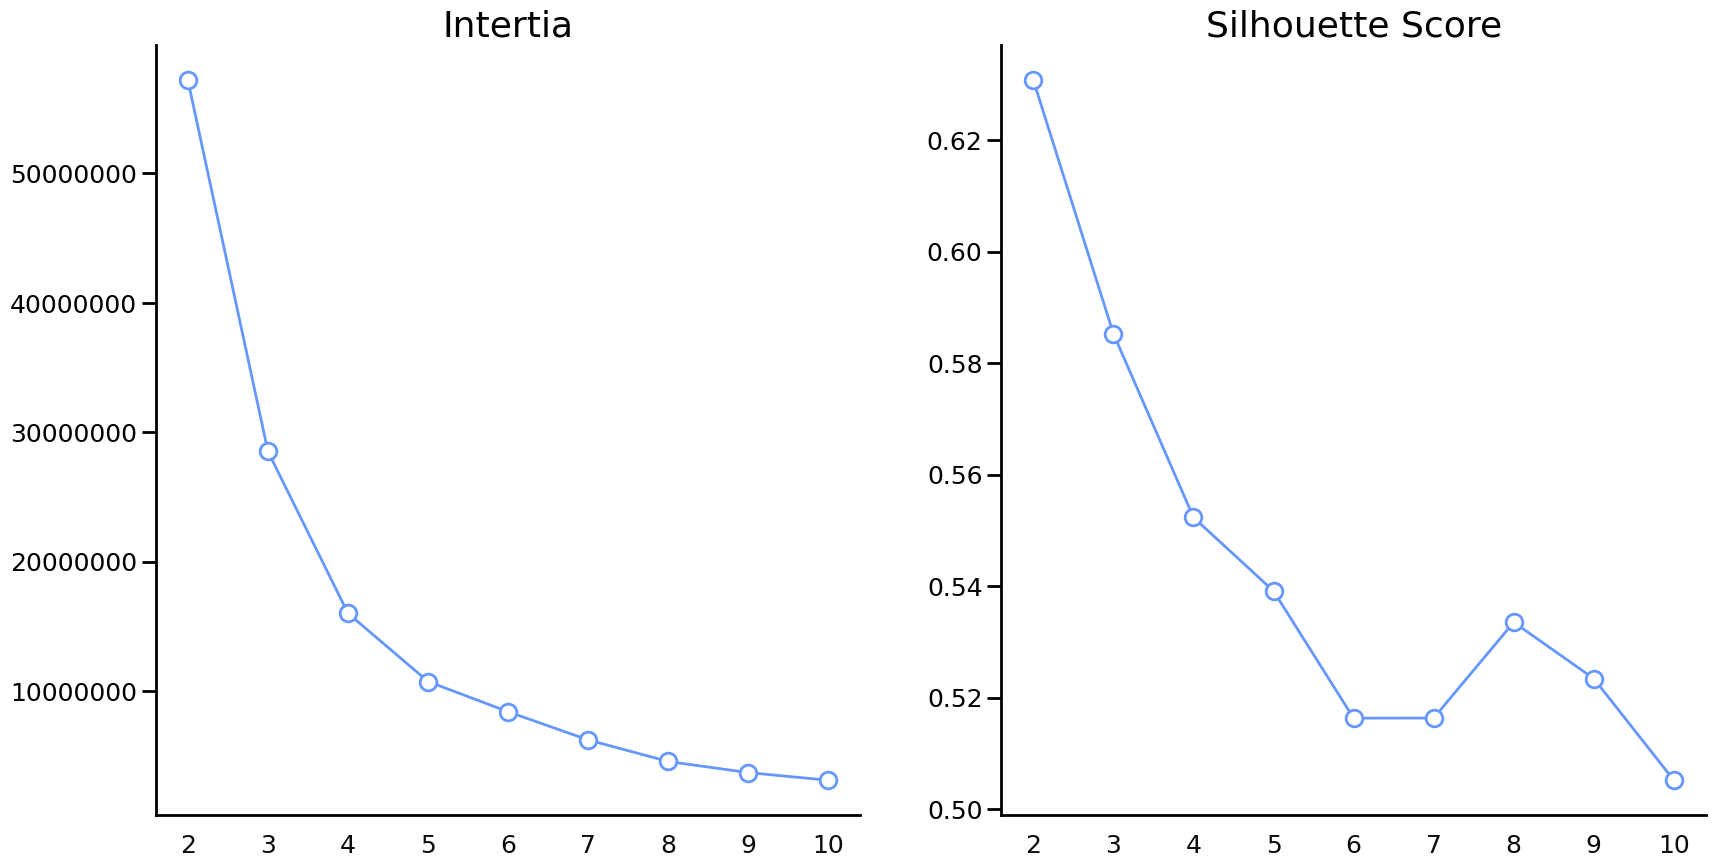

In [59]:
#Graph it!
fix, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.ticklabel_format(style='plain')
ax1.plot(range(2,11),in_score)
ax2.plot(range(2,11),sil_score)
ax1.set_title( 'Intertia')
ax2.set_title('Silhouette Score');


## Interpretation

We know there are more than two kinds of penguins running around, so we can't choose that for our cluster number.

Reading the Elbow plot (inertia), there is a change at both three and four.

If we look at the Silhouette Score plot, besides two, three has the highest score.

So, on looking at both plots, we'll select three clusters for our number

## Visualization of Clusters

Since we are going to use three clusters, let's look at how to create some visualizations.

We are going to use PCA, which you will cover later in the course.

There are currently nine dimensions in our dataset. We can't show them all.

Using PCA we will reduce that to three and then two dimensions to visualize our cluster.


In [67]:
# Instantiate KMeans with three clusters, and capture the labels
k_means = KMeans(n_clusters=3)
labels = k_means.fit_predict(ohe_df)

The next takes a bit of explanation.

We are going to instantiate the PCA algorithm and tell it to give us three dimensions.

The `.fit_transform()` method takes the input, and returns the transformed data. This is functionaly eqivalent of doing each step seperately.

We then add the labels for each observation.

In [1]:
# Instantiate
three_d_pca = PCA(n_components=3)

# Create a dataframe with the three components
df_three = pd.DataFrame(three_d_pca.fit_transform(ohe_df), columns=['pca1','pca2','pca3'])

# Add the labels
df_three['label'] = labels

# Sanity Check!
df_three.head()

NameError: name 'PCA' is not defined

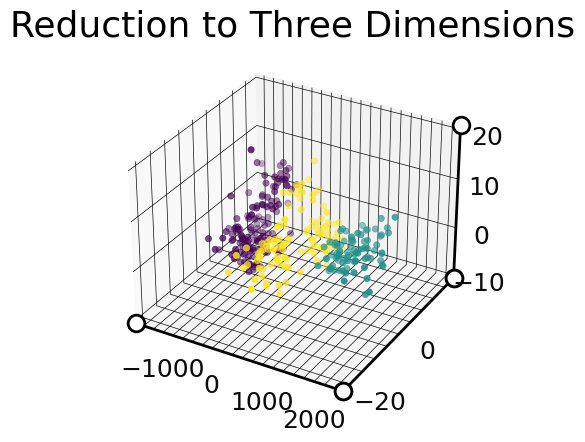

In [117]:
# This will create a 3D scatter plot

fig = plt.figure()

ax = plt.subplot(projection='3d')

ax.scatter(df_three.pca1, df_three.pca2, df_three.pca3, c=df_three.label)

ax.set_title('Reduction to Three Dimensions');


We will now do the same thing, but reduce the number of dimensions down to two

In [69]:
two_d_pca = PCA(n_components=2)
df_two = pd.DataFrame(two_d_pca.fit_transform(ohe_df), columns=['pca1','pca2'])
df_two['label'] = labels

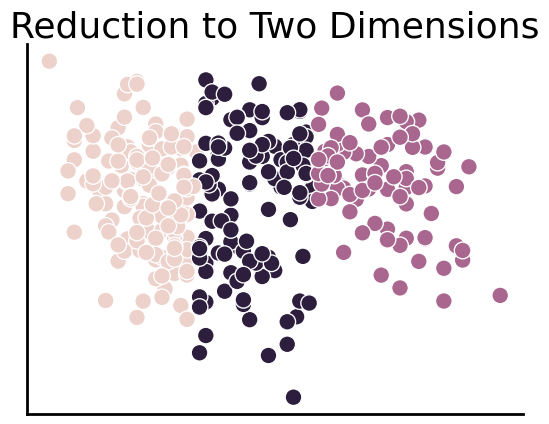

In [94]:
# Using seaborn scatter plot to show two dimensions
fig, ax = plt.subplots(1)
sns.scatterplot(data=df_two, x='pca1',y='pca2',hue='label', ax=ax, legend=False)
ax.set_title('Reduction to Two Dimensions')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False);
